<a href="https://colab.research.google.com/github/vicmcl/malaria-detection/blob/main/malaria-detection/notebook_malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

In [37]:
%reload_ext autoreload
%autoreload 2

In [1]:
!git clone https://github.com/vicmcl/malaria-detection.git

Cloning into 'malaria-detection'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 119 (delta 61), reused 84 (delta 42), pack-reused 0
Receiving objects: 100% (119/119), 499.61 KiB | 7.57 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [28]:
!git pull origin main

remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 10 (delta 8), reused 6 (delta 4), pack-reused 0
Unpacking objects: 100% (10/10), 1002 bytes | 200.00 KiB/s, done.
From https://github.com/vicmcl/malaria-detection
 * branch            main       -> FETCH_HEAD
   923e67f..1854ac6  main       -> origin/main
Updating 923e67f..1854ac6
Fast-forward
 malaria-detection/utils/plots.py | 21 ++++++++++++++++++++-
 1 file changed, 20 insertions(+), 1 deletion(-)


## **Mount the Drive**

In [2]:
from google.colab import userdata

username = userdata.get('KAGGLE_USERNAME')
api_key = userdata.get('KAGGLE_KEY')

In [3]:
import os
import subprocess
import json

KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')
os.makedirs(KAGGLE_CONFIG_DIR, exist_ok = True)
api_dict = {"username":username, "key":api_key}

with open(f"{KAGGLE_CONFIG_DIR}/kaggle.json", "w", encoding='utf-8') as f:
    json.dump(api_dict, f)

cmd = f"chmod 600 {KAGGLE_CONFIG_DIR}/kaggle.json"
output = subprocess.check_output(cmd.split(" "))
output = output.decode(encoding='UTF-8')

print(output)

In [4]:
os.chdir("malaria-detection/malaria-detection")

In [31]:
!python utils/get_dataset.py

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria


In [38]:
from utils.checkpoint import checkpoint
from utils.plots import plot_images, plot_training, settings
from utils.prediction import prediction
from utils.preprocessing import preprocess_data

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns

DATA_PATH = os.path.abspath("data/cell_images")
settings()

ImportError: cannot import name 'plot_training' from 'utils.plots' (/content/malaria-detection/malaria-detection/utils/plots.py)

In [7]:
x_train, x_test, y_train, y_test = preprocess_data(DATA_PATH)

In [11]:
print(x_train.shape)
print(x_test.shape)

(22046, 64, 64, 3)
(5512, 64, 64, 3)


In [17]:
pd.Series(y_test).value_counts()

1    2756
0    2756
Name: count, dtype: int64

#### **Countplots**

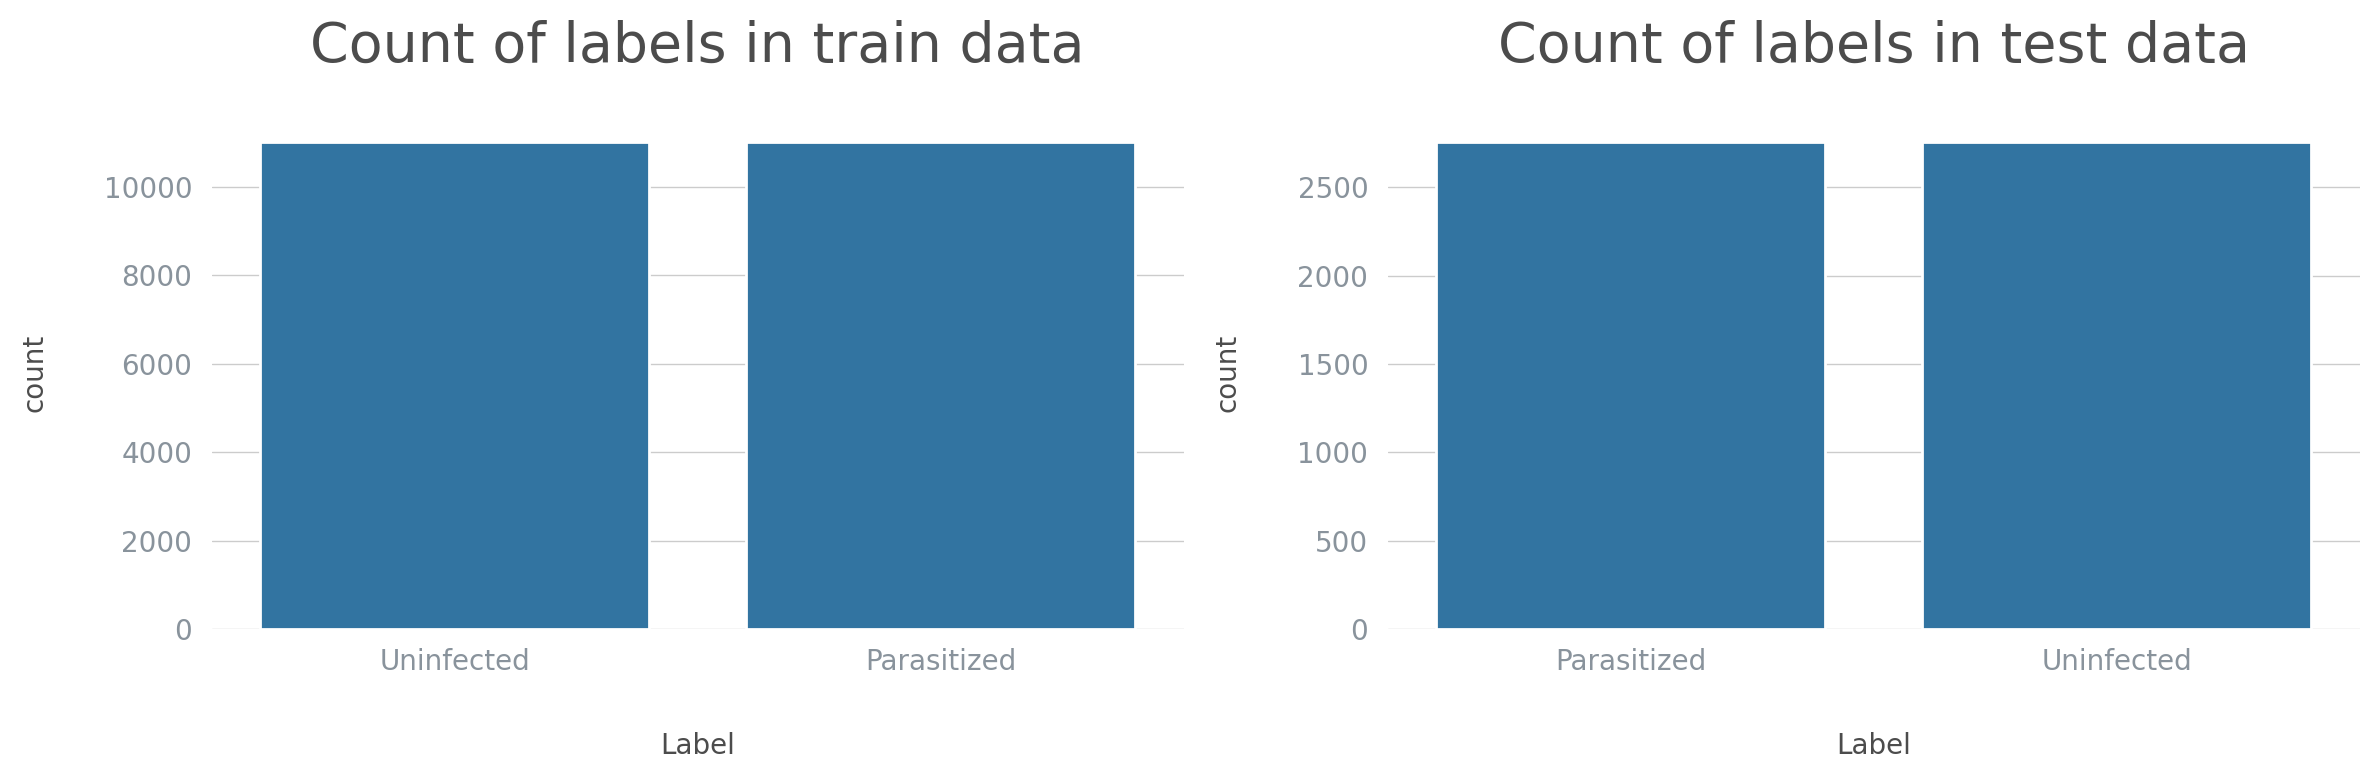

In [23]:
fig = plt.figure(figsize = (12, 4))
labels = ["Uninfected", "Parasitized"]

# Create two dataframe to associate each image with its label
for i, data in enumerate([(x_train, y_train), (x_test, y_test)]):
    df = pd.DataFrame(
        zip(data[0], data[1]), columns = ["Image", "Label"]
    )
    fig.add_subplot(1, 2, i + 1)
    for j, lab in enumerate(labels):
        df["Label"] = df["Label"].replace(j, lab)

    # Plot the countplot of labels in df_train
    sns.countplot(data = df, x = "Label")

    title = "train" if i == 0 else "test"
    plt.gca().set_title(f"Count of labels in {title} data")

plt.tight_layout()
plt.show()

- The training dataset is well balanced with a 50/50 split between the images of parasitized and uninfected cells. Therefore, the models should be able to train on a similar number of images of parasitized and uninfected cells, which is likely to improve the results against new data.

#### **Visualization**

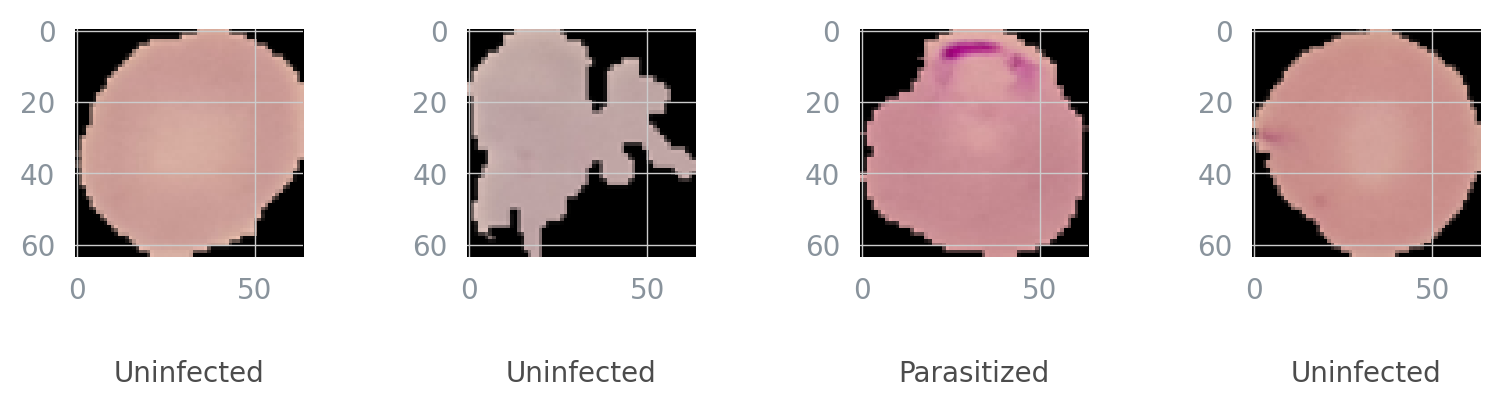

In [27]:
plot_images(x_train, y_train, 4)

## **CNN**

In [ ]:
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.random import set_seed

from tensorflow.keras import backend, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    LeakyReLU,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
)


####<b>One Hot Encoding the train and test labels</b>

In [ ]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

#### **Plotting the training and validation loss**

In [ ]:
def plot_training(hist):
    # Loss on the training data
    plt.plot(range(1, len(hist.epoch) + 1), hist.history['loss'])

    # Loss on the validation data
    plt.plot(range(1, len(hist.epoch) + 1), hist.history['val_loss'])

    # Axis parameters
    plt.ylim(0, 1)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

#### **Plotting the confusion matrix**

In [ ]:
def report_and_matrix(test, pred):
    # Print the classification report
    report = classification_report(test, pred)

    print(report)
    print("----------------------------------------------------------------------")
    print()

    # Plot the confusion matrix
    cm = tf.math.confusion_matrix(test, pred)
    ax = sns.heatmap(
            cm,
            annot = True,
            linewidths = 0.4,
            fmt = "d",
            square = True,
         )

    ax.set(
        xlabel = 'Predicted Labels',
        ylabel = 'True Labels',
    )

    plt.show()

    # Return the report and the confusion matrix in a dictionary
    return {"report": report, "matrix": cm}

In [ ]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

#### **Building the model**

In [ ]:
# Sequential model
model = Sequential(
    name = "Light_CNN",
    layers = [
        Conv2D(
            filters = 32,
            kernel_size = 2,
            padding = "same",
            activation = "relu",
            input_shape = (64, 64, 3),
        ),
        MaxPooling2D(pool_size = 2),
        Dropout(rate = 0.3),
        Conv2D(
            filters = 64,
            kernel_size = 2,
            padding = "same",
            activation = "relu",
        ),
        MaxPooling2D(pool_size = 2),
        Dropout(rate = 0.3),
        Conv2D(
            filters = 128,
            kernel_size = 2,
            padding="same",
            activation="relu",
        ),
        MaxPooling2D(pool_size = 2),
        Dropout(rate = 0.3),
        Flatten(),
        Dense(
            units = 128,
            activation = "relu",
        ),
        Dropout(rate = 0.5),
        Dense(2, activation = 'softmax')
    ]
)

model.summary()
model.compile(
    loss="binary_crossentropy",
    optimizer = Adam(learning_rate = 0.0005),
    metrics = ["accuracy"]
)

history= model.fit(
    x_train,
    y_train_encoded,
    epochs=100,
    callbacks=checkpoint("weights_model_1.hdf5"),
    validation_split=0.2,
    batch_size=32,
    verbose=1
)

#### **Plotting the train and the validation curves**

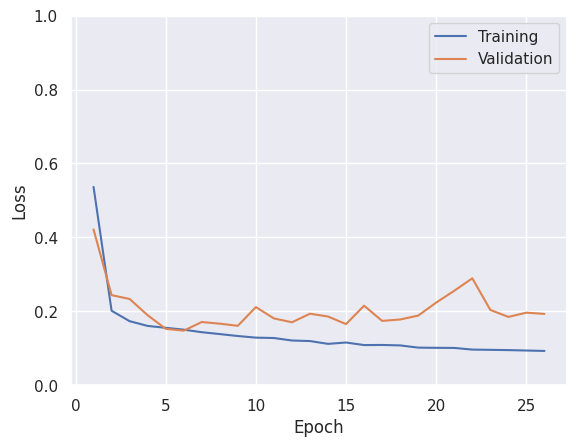

In [ ]:
plot_training(history_1)

The model overfits the training data, as the loss does not decrease on the validation set.

#### **Evaluating the model**

In [ ]:
test_1, pred_1 = prediction(m_1, x_test, y_test_encoded)

82/82 [==============================] - 0s 3ms/step


#### **Plotting the confusion matrix**

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1300
           1       0.98      0.95      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600

----------------------------------------------------------------------



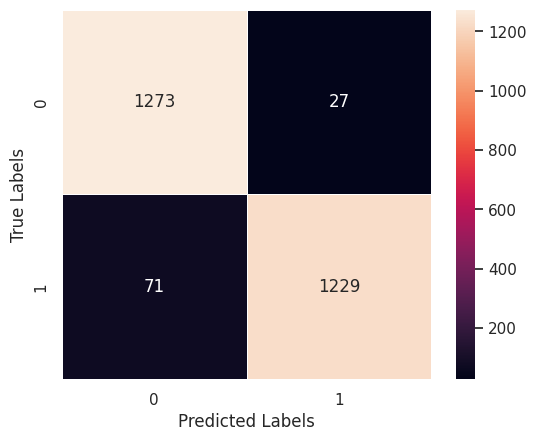

In [ ]:
stat_1 = report_and_matrix(test_1, pred_1)

- Label 0 = uninfected, label 1 = parasitized
- This model reaches a 96% accuracy on the test data. It misclassified 98 cells, including 71 false negatives. It is critical to minimize this number which represents the parasitized cells predicted as uninfected, in the case of a diagnosis.

## **Data Augmentation**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the training data into training images/labels and validation images/labels with a ratio of 80%/20%
x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(x_train,
                                                                  y_train_encoded,
                                                                  test_size=0.2,
                                                                  random_state=42)

# Parameters to generate new images
generator = ImageDataGenerator(
                horizontal_flip=True, # Can flip the image upside down
                zoom_range=0.5,       # Can zoom in the image up to 2x
                rotation_range=30     # Can rotate the image up to 30°
            )

# Create an iterator with new images
augmented_data = generator.flow(
                    x=x_train_aug,
                    y=y_train_aug,
                    batch_size=32,
                    seed=42,
                    shuffle=True
                 )

In [ ]:
m_2 = model_1()

In [ ]:
history_2 = m_2.fit(
                augmented_data,
                epochs=100,
                callbacks=checkpoint("MyDrive/weights_model_5.hdf5"),
                validation_data=(x_val_aug, y_val_aug),
                verbose=1
            )

Epoch 1/100
624/624 [==============================] - 28s 41ms/step - loss: 0.6360 - accuracy: 0.6434 - val_loss: 0.4936 - val_accuracy: 0.8780
Epoch 2/100
  1/624 [..............................] - ETA: 37s - loss: 0.6695 - accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


624/624 [==============================] - 26s 41ms/step - loss: 0.3389 - accuracy: 0.8800 - val_loss: 0.1889 - val_accuracy: 0.9321
Epoch 3/100
624/624 [==============================] - 26s 41ms/step - loss: 0.2773 - accuracy: 0.8992 - val_loss: 0.1837 - val_accuracy: 0.9309
Epoch 4/100
624/624 [==============================] - 26s 41ms/step - loss: 0.2654 - accuracy: 0.9078 - val_loss: 0.1704 - val_accuracy: 0.9447
Epoch 5/100
624/624 [==============================] - 25s 41ms/step - loss: 0.2518 - accuracy: 0.9097 - val_loss: 0.1652 - val_accuracy: 0.9481
Epoch 6/100
624/624 [==============================] - 25s 40ms/step - loss: 0.2454 - accuracy: 0.9141 - val_loss: 0.1769 - val_accuracy: 0.9497
Epoch 7/100
624/624 [==============================] - 25s 41ms/step - loss: 0.2432 - accuracy: 0.9179 - val_loss: 0.1644 - val_accuracy: 0.9527
Epoch 8/100
624/624 [==============================] - 26s 41ms/step - loss: 0.2391 - accuracy: 0.9180 - val_loss: 0.1619 - val_accuracy: 0.95

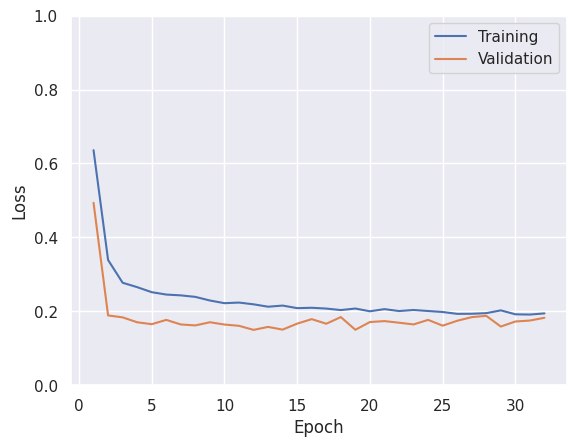

In [ ]:
plot_training(history_2)

In [ ]:
test_2, pred_2 = prediction(m_2, x_test, y_test_encoded)

82/82 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1300
           1       0.98      0.94      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600

----------------------------------------------------------------------



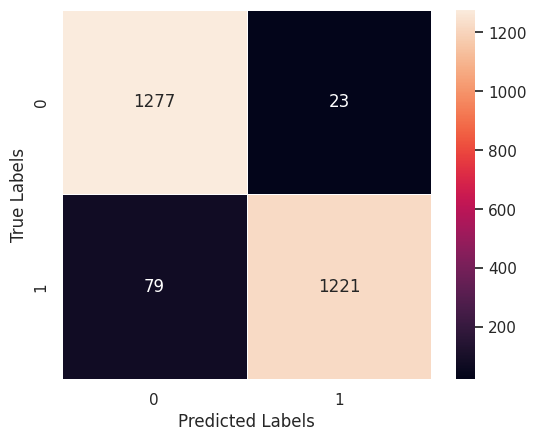

In [ ]:
stat_5 = report_and_matrix(test_2, pred_2)

- The accuracy is again rounded to 96%, but with 102 misclassification this time, including only 79 false negatives.
- Data augmentation provides a tool to make the training more robust with more general features learned via the distorsion of the images. It helps reduce overfitting, as seen in the loss plot: the validation loss remains inferior to the training loss at all epoch.
